In [1]:
import cmctoolkit as cmct

import numpy as np
import matplotlib.pyplot as plt

The $\texttt{cmctoolkit}$ is a set of python functions to quickly process the globular cluster (GC) simulation data for $\texttt{Cluster Monte Carlo}$ ($\texttt{CMC}$) code, especially the large grid recently released by Kremer et al. 2020 (DOI: 10.3847/1538-4365/ab7919, https://cmc.ciera.northwestern.edu/home/). An example of its usage can be found in Rui, in prep. to match GC simulations to surface brightness and velocity dispersion data.

The code revolves around a $\texttt{Snapshot}$ object, which takes as arguments the snapshot filename, conversion file, and optionally the distance and metallicity. In order to demonstrate some possibilities for this code, we provide a few examples by examining the $\textbf{N8-RV1-RG8-Z0.1}$ model.

In [2]:
# Read snapshot 0382 of n8-rv1-rg8-z0.1
snap = cmct.Snapshot(fname='N8-RV1-RG8-Z0.1/initial.snap0382.dat.gz',
                      conv='N8-RV1-RG8-Z0.1/initial.conv.sh',
                      dist=15, # distance to cluster in kpc
                         z=0.02*0.1
                    )

# Print the simulated star catalog
print(snap.data)

              id    m[MSUN]          r        vr        vt         E  \
0            0.0  29.821064   0.031337 -0.048657  0.011852 -0.167726   
1       383270.0   0.496501   0.035258  0.388841  0.363856 -0.026968   
2       235229.0   0.125810   0.043891 -0.212199  0.245219 -0.115833   
3       130602.0   1.242000   0.048774  0.125371  0.243344 -0.130803   
4       543805.0   0.770915   0.052481 -0.181663  0.105104 -0.146151   
...          ...        ...        ...       ...       ...       ...   
682578  564437.0   0.119351  63.854536 -0.013345  0.000321 -0.007167   
682579  470918.0   0.107544  63.909288 -0.002542  0.006217 -0.007227   
682580  327456.0   0.269878  63.974174  0.007704  0.002889 -0.007208   
682581   38418.0   0.267489  64.000091 -0.012462  0.000791 -0.007161   
682582  434745.0   0.088851  64.197640  0.003873  0.002622 -0.007206   

               J  binflag    m0[MSUN]    m1[MSUN]  ...  bacc1  tacc0  tacc1  \
0       0.000371      1.0   16.283503   13.537561  ...  

One is free to easily recover the snapshot age:

In [3]:
print(snap.age) # Gyr

12.732264843402001


Behind the scenes, $\texttt{CMC}$ works in code units which are not immediately physically identifiable. Conversion between code units and physical units are encoded in the $\texttt{convert_units}$ method. Note that quantities which are dimensionally identical but applied at physically different scales are sometimes identified with two different code units. For example, there are different code units for time in terms of the cluster age and time for the purpose of calculating stellar velocities.

Startypes follow the SSE/BSE conventions of Hurley 2000, 2002:
* 0 - deeply or fully convective low mass MS star
* 1 - Main Sequence star
* 2 - Hertzsprung Gap
* 3 - First Giant Branch
* 4 - Core Helium Burning
* 5 - First Asymptotic Giant Branch
* 6 - Second Asymptotic Giant Branch
* 7 - Main Sequence Naked Helium star
* 8 - Hertzsprung Gap Naked Helium star
* 9 - Giant Branch Naked Helium star
* 10 - Helium White Dwarf
* 11 - Carbon/Oxygen White Dwarf
* 12 - Oxygen/Neon White Dwarf
* 13 - Neutron Star
* 14 - Black Hole
* 15 - Massless Supernova

0         5.931405e+31
1         9.875399e+29
2         2.502359e+29
3         2.470336e+30
4         1.533348e+30
              ...     
682578    2.373887e+29
682579    2.139049e+29
682580    5.367867e+29
682581    5.320352e+29
682582    1.767239e+29
Name: m[MSUN], Length: 682583, dtype: float64


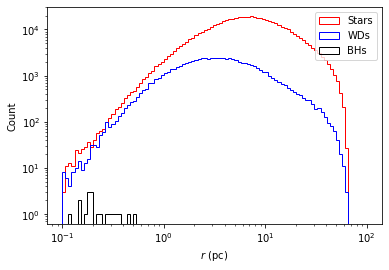

In [4]:
# Convert stellar mass from solar masses to kg
print(snap.convert_units(snap.data['m[MSUN]'], # [MSUN] indicates units already given in solar masses
                 in_unit='msun',
                out_unit='kg'))

# Plot radial distribution of stars, white dwarfs, and black holes separately for single objects
binflag = (snap.data['binflag'] == 1) # binarity flag
startype_star = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
startype_wd = np.array([10, 11, 12])
startype_bh = np.array([14])

r = snap.convert_units(snap.data['r'], # distance to cluster center in pc
               in_unit='code',
              out_unit='pc')

starflag = np.in1d(snap.data['startype'], startype_star)
wdflag = np.in1d(snap.data['startype'], startype_wd)
bhflag = np.in1d(snap.data['startype'], startype_bh)

bins = np.logspace(-1, 2, 100)

plt.hist(r[starflag & ~binflag], bins, color='r', histtype='step', label='Stars')
plt.hist(r[wdflag & ~binflag], bins, color='b', histtype='step', label='WDs')
plt.hist(r[bhflag & ~binflag], bins, color='k', histtype='step', label='BHs')

plt.legend(loc='upper right')
plt.xlabel('$r$ (pc)')
plt.ylabel('Count')
plt.xscale('log')
plt.yscale('log')

plt.show()

Here, we plot the projected positions and velocities for single stars, white dwarfs, and black holes separately after adopting a random seed to project stars into random solid angles in the cluster (CMC assumes spherical symmetry). Unit conversion is handled automatically.

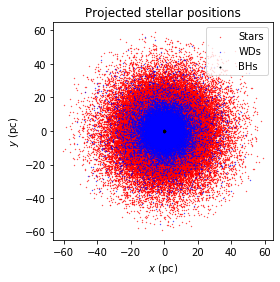

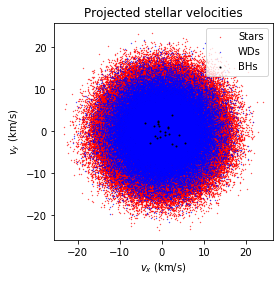

In [5]:
# Generate random solid angle positions, append additional quantities
snap.make_2d_projection(seed=8675309)

X = snap.data['x[PC]']
Y = snap.data['y[PC]']
VX = snap.data['vx[KM/S]']
VY = snap.data['vy[KM/S]']

# Plot stellar positions
plt.scatter(X[starflag & ~binflag], Y[starflag & ~binflag], c='r', s=0.1, label='Stars')
plt.scatter(X[wdflag & ~binflag], Y[wdflag & ~binflag], c='b', s=0.1, label='WDs')
plt.scatter(X[bhflag & ~binflag], Y[bhflag & ~binflag], c='k', s=1, label='BHs')

plt.gca().set_aspect('equal')

plt.legend(loc='upper right')
plt.xlabel('$x$ (pc)')
plt.ylabel('$y$ (pc)')
plt.title('Projected stellar positions')

plt.show()

# Plot stellar positions
plt.scatter(VX[starflag & ~binflag], VY[starflag & ~binflag], c='r', s=0.1, label='Stars')
plt.scatter(VX[wdflag & ~binflag], VY[wdflag & ~binflag], c='b', s=0.1, label='WDs')
plt.scatter(VX[bhflag & ~binflag], VY[bhflag & ~binflag], c='k', s=1, label='BHs')

plt.gca().set_aspect('equal')

plt.legend(loc='upper right')
plt.xlabel('$v_x$ (km/s)')
plt.ylabel('$v_y$ (km/s)')
plt.title('Projected stellar velocities')

plt.show()

We plot the single star mass function below, as well as the mass function for all stars in the cluster.

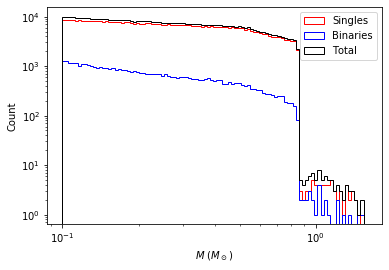

In [6]:
# Get all masses and classifications
singlestar_mass = snap.data['m[MSUN]']
binstar0_mass = snap.data['m0[MSUN]']
binstar1_mass = snap.data['m1[MSUN]']

startypes_single = snap.data['startype']
startypes_bin0 = snap.data['bin_startype0']
startypes_bin1 = snap.data['bin_startype1']

masses = np.concatenate((singlestar_mass[~binflag & starflag],
                         binstar0_mass[binflag & np.in1d(startypes_bin0, startype_star)],
                         binstar1_mass[binflag & np.in1d(startypes_bin1, startype_star)]
                        ))
binflag_tot = np.concatenate((np.zeros(len(singlestar_mass[~binflag & starflag])),
                              np.ones(len(binstar0_mass[binflag & np.in1d(startypes_bin0, startype_star)])),
                              np.ones(len(binstar1_mass[binflag & np.in1d(startypes_bin1, startype_star)]))
                             )).astype(bool)

# Plot histogram
bins = np.logspace(-1, 0.2, 100)

plt.hist(masses[~binflag_tot], bins, color='r', histtype='step', label='Singles')
plt.hist(masses[binflag_tot], bins, color='b', histtype='step', label='Binaries')
plt.hist(masses, bins, color='k', histtype='step', label='Total')

plt.legend(loc='upper right')
plt.xlabel('$M$ ($M_\odot$)')
plt.ylabel('Count')
plt.xscale('log')
plt.yscale('log')

plt.show()

Alternatively, you can call the hardcoded method to generate a mass function within some cuts and fit its slope.

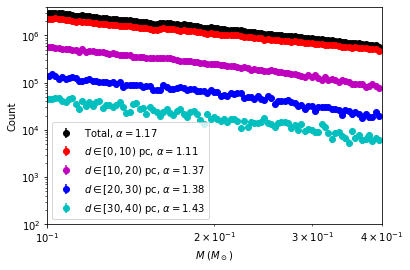

In [17]:
bin_edges = np.logspace(-1, -0.4, 100) # range: 0.1 to 0.4 solar masses
d_bins = [0, 10, 20, 30, 40] # projected distance from the cluster: d

# Make mass function
mf, e_mf = snap.make_mass_function(bin_edges,
                         startypes=startype_star)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])

# Fit total mass function slope for this mass range
tot_slope = snap.fit_mass_function_slope(init_guess=1.3,
                                           min_mass=0.1,
                                           max_mass=0.4,
                                              dmin=None,
                                              dmax=None,
                                         startypes=startype_star)

plt.errorbar(bin_centers, mf, e_mf, fmt='ko',
             label=f'Total, $\\alpha={tot_slope:.2f}$')

formats = ['ro', 'mo', 'bo', 'co']

for ii in range(len(d_bins) - 1):
    # Make mass function for specific d range
    mf, e_mf = snap.make_mass_function(bin_edges,
                             startypes=startype_star,
                                  dmin=d_bins[ii],
                                  dmax=d_bins[ii+1]
                                      )
    bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    
    # Fit mass function slope for specific d range
    tot_slope = snap.fit_mass_function_slope(init_guess=1.3,
                                               min_mass=0.1,
                                               max_mass=0.4,
                                                   dmin=d_bins[ii],
                                                   dmax=d_bins[ii+1],
                                              startypes=startype_star)
    
    plt.errorbar(bin_centers, mf, e_mf, fmt=formats[ii],
                 label=f'$d\\in[{d_bins[ii]}, {d_bins[ii+1]})$ pc, $\\alpha={tot_slope:.2f}$')

plt.legend(loc='lower left')
plt.xlabel('$M$ ($M_\odot$)')
plt.ylabel('Count')
plt.xlim(0.1, 0.4)
plt.ylim(1e2, 4e6)
plt.xscale('log')
plt.yscale('log')

plt.show()

things to add:
* number density profile
* surface brightness profile, discussion of filters
* read in all the sbps, vdps, and show an example comparison
* parameter dictionary, write documentation of what these things are